In [1]:
from yasai_funcs import yasai
import torch
import cv2
from torchvision import transforms
import numpy as np
import matplotlib.pyplot as plt
import os
from torch.utils.data import Dataset, DataLoader
import pandas as pd
from PIL import Image
from skimage.transform import resize

In [2]:
model = yasai.model_load_v1('./../lab_10/model_bast_ima_2305151053.pt')

Successfully loaded from ./../lab_10/model_bast_ima_2305151053.pt


In [3]:
yasai.model_checker_v1(model, (32, 3, 224, 224))

give_model torch.Size([32, 3, 224, 224])
got_from_model torch.Size([32, 4, 224, 224])


/home/yasaisen/.local/lib/python3.8/site-packages/segmentation_models_pytorch/base/modules.py:116: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self.activation(x)


In [4]:
ROOT_PATH = '/home/yasaisen/Desktop/09_research/09_research_main/lab_03'

In [5]:
dataset_folder = 'dataset_C_v_2.9.3'

train_img_path = os.path.join(ROOT_PATH, dataset_folder, 'train_for_step_imgs')

valid_img_path = os.path.join(ROOT_PATH, dataset_folder, 'valid_imgs_rgb')

test_img_path = os.path.join(ROOT_PATH, dataset_folder, 'test_imgs_rgb')

In [6]:
def yasai_get_path_df_v1(img_path):
    images = []
    i = 0
    for get_img_name in os.listdir(img_path):
        images += [os.path.join(img_path, get_img_name)]
        i = i+1
    PathDF = pd.DataFrame({'images': images})
    print(i)
    PathDF.head()
    return PathDF

In [7]:
train_df = yasai_get_path_df_v1(train_img_path)
valid_df = yasai_get_path_df_v1(valid_img_path)
test_df = yasai_get_path_df_v1(test_img_path)

11364
1037
917


In [8]:
class mod_Dataset(Dataset):
    def __init__(self, path_df, transform=None):
        self.path_df = path_df
        self.transform = transform

    def __len__(self):
        return self.path_df.shape[0]
    
    def __getitem__(self, idx):
        trans_Resize = transforms.Resize(224)
        trans_ToTensor = transforms.ToTensor()

        path = self.path_df.iloc[idx]['images']

        images = trans_Resize(Image.open(path).convert('RGB'))
        images = trans_ToTensor(images)

        return images, path.split('/')[-1]

In [9]:
train_data = mod_Dataset(train_df)
valid_data = mod_Dataset(valid_df)
test_data = mod_Dataset(test_df)

In [10]:
def visualize(**images):
    n = len(images)
    plt.figure(figsize=(16, 5))
    for i, (name, image) in enumerate(images.items()):
        plt.subplot(1, n, i + 1)
        plt.xticks([])
        plt.yticks([])
        plt.title(' '.join(name.split('_')).title())
        plt.imshow(image)
    plt.show()

In [11]:
def yasai_show_v2(dataset, idx, model=None):
    image, name = dataset[idx]
    if model is not None:
        pred = model(image.unsqueeze(0).cuda())
        with torch.no_grad():
            pred = np.asarray(pred.cpu()).squeeze()
    with torch.no_grad():
        image = np.asarray(image.cpu()).transpose(1, 2, 0)

    if model is not None:
        tempdict = {}
        tempdict['image'] = image
        for i in range(pred.shape[0]):
            tempdict['pred_' + str(i)] = 0.4 * yasai.round(pred[i]) + 0.6 * image[...,0].squeeze()
        visualize(**tempdict)

    if model is not None:
        tempdict = {}
        tempdict['image'] = image
        for i in range(pred.shape[0]):
            tempdict['pred_' + str(i)] = pred[i]
        visualize(**tempdict)

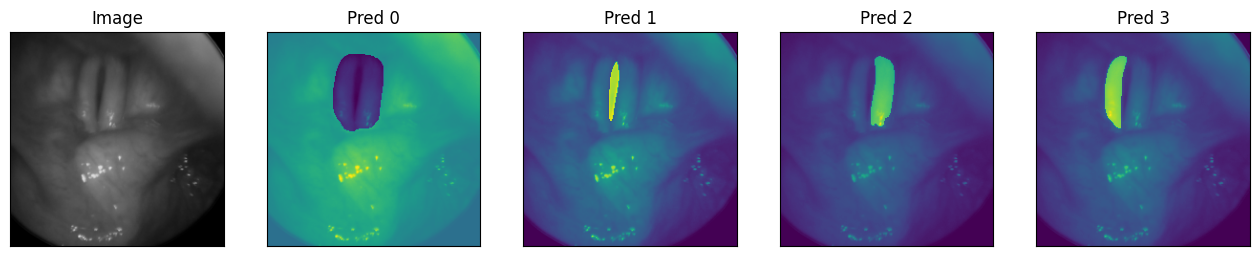

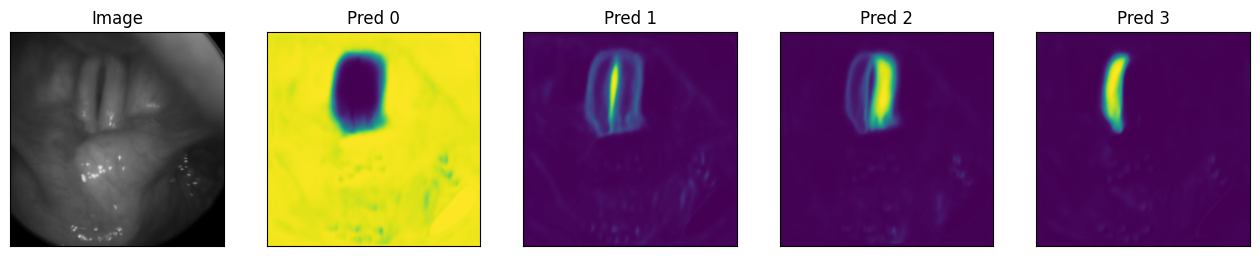

In [12]:
yasai_show_v2(train_data, 5, model)

In [13]:
def bounding2square(x, y, w, h, img_size):
  if w >= h:
    y = int(y - (h / 4))
    if y < 0 : y = 0
    h = w
    if y + h > img_size : y = img_size - h
  else:
    x = int(x - (w / 4))
    if x < 0 : x = 0
    w = h
    if x + w > img_size : x = img_size - w
  return x, y, w, h

In [14]:
def bounding_crop(image, model):
  pred = model(image.unsqueeze(0).cuda())
  with torch.no_grad():
      pred = np.asarray(pred.cpu()).squeeze()
      image = np.asarray(image).transpose(1, 2, 0)

  # image = cv2.resize(image, (1080, 1080))
  # pred = cv2.resize(pred, (1080, 1080))

  temp = yasai.round(pred[0])

  for i in range(0, temp.shape[0]):
    for j in range(0, temp.shape[1]):
      if temp[i][j] == 1.0:
        image[i][j][0] = 255
        image[i][j][1] = 255
        image[i][j][2] = 255

  # Convert the image to grayscale
  gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

  # Convert the grayscale image to 8-bit single-channel
  gray_8bit = cv2.convertScaleAbs(gray)

  # Threshold the image using Otsu's thresholding
  _, thresh = cv2.threshold(gray_8bit, 0, 255, cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU)

  # Find contours in the binary mask
  contours, _ = cv2.findContours(thresh, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

  # Find the contour with the largest area
  max_area = 0
  max_contour = None

  for contour in contours:
      area = cv2.contourArea(contour)
      if area > max_area:
          max_area = area
          max_contour = contour

  # Get the bounding rectangle of the largest contour
  x, y, w, h = cv2.boundingRect(max_contour)

  x, y, w, h = bounding2square(x, y, w, h, 224)

  # Crop and resize the image
  cropped_image = image[y:y+h, x:x+w]

  resized_image = cv2.resize(cropped_image, (image.shape[1], image.shape[0]))*255

  resized_image = cv2.cvtColor(resized_image, cv2.COLOR_BGR2RGB)

  return resized_image

# tempdict = {}
# tempdict['image'] = cropped_image
# visualize(**tempdict)

In [15]:
path = os.path.join(ROOT_PATH, '../lab_11', 'finetune_train_set_gs')
yasai.checkpath(path)
for image, name in train_data:
    croped_image = bounding_crop(image, model)
    print(name)
    cv2.imwrite(os.path.join(path, name), croped_image)

yasai.success()

RLN_L_G11_Lid16_LRid198_Gid1047_Bu30.png
NORMAL_G18_Lid52_LRid451_Gid3998_Bu30.png
RSLN_R_G8_Lid28_LRid367_Gid9335_Bu30.png
RLN_R_G13_Lid52_LRid338_Gid4949_Bu30.png
RLN_L_G5_Lid100_LRid130_Gid1313_Bl30.png
RLN_R_G14_Lid144_LRid431_Gid6326_Bl30.png
RSLN_L_G14_Lid12_LRid139_Gid7923_Bu30.png
RLN_R_G3_Lid8_LRid525_Gid6040_Bn00.png
NORMAL_G11_Lid48_LRid521_Gid3391_Bu30.png
RLN_R_G13_Lid50_LRid167_Gid4947_Bl30.png
RLN_R_G13_Lid10_LRid345_Gid4907_Bn00.png
RLN_R_G4_Lid152_LRid665_Gid4809_Bl30.png
RLN_R_G8_Lid22_LRid366_Gid5245_Bl30.png
RSLN_L_G9_Lid112_LRid177_Gid7653_Bn00.png
NORMAL_G20_Lid6_LRid175_Gid4161_Bl30.png
RLN_L_G22_Lid130_LRid226_Gid2217_Bu30.png
RLN_R_G14_Lid202_LRid272_Gid6384_Bu30.png
RLN_R_G14_Lid122_LRid354_Gid6304_Bn00.png
RLN_R_G1_Lid128_LRid944_Gid5502_Bl30.png
NORMAL_G18_Lid176_LRid480_Gid4122_Bn00.png
RSLN_R_G4_Lid32_LRid274_Gid9086_Bn00.png
NORMAL_G12_Lid148_LRid157_Gid3695_Bl30.png
RLN_L_G22_Lid208_LRid218_Gid2295_Bl30.png
RLN_R_G13_Lid244_LRid449_Gid5141_Bu30.png
RLN_L

In [16]:
path = os.path.join(ROOT_PATH, '../lab_11', 'finetune_valid_set')
yasai.checkpath(path)
for image, name in valid_data:
    croped_image = bounding_crop(image, model)
    print(name)
    cv2.imwrite(os.path.join(path, name), croped_image)

yasai.success()

RLN_R_VALID_G21_Lid159_LRid331_Gid991_Bnrgb.png
RLN_R_VALID_G21_Lid130_LRid423_Gid962_Bnrgb.png
RLN_R_VALID_G21_Lid185_LRid324_Gid1017_Bnrgb.png
RSLN_L_VALID_G25_Lid70_LRid456_Gid2399_Bnrgb.png
RLN_R_VALID_G21_Lid52_LRid418_Gid884_Bnrgb.png
RSLN_L_VALID_G25_Lid38_LRid426_Gid2367_Bnrgb.png
NORMAL_VALID_G30_Lid143_LRid294_Gid332_Bnrgb.png
NORMAL_VALID_G30_Lid110_LRid152_Gid299_Bnrgb.png
RSLN_R_VALID_G21_Lid131_LRid332_Gid4488_Bnrgb.png
RLN_R_VALID_G21_Lid34_LRid379_Gid866_Bnrgb.png
RSLN_R_VALID_G21_Lid74_LRid362_Gid4431_Bnrgb.png
RLN_L_VALID_G25_Lid85_LRid360_Gid85_Bnrgb.png
RLN_R_VALID_G21_Lid80_LRid360_Gid912_Bnrgb.png
RSLN_R_VALID_G21_Lid52_LRid479_Gid4409_Bnrgb.png
RLN_L_VALID_G25_Lid131_LRid221_Gid131_Bnrgb.png
RSLN_R_VALID_G21_Lid136_LRid330_Gid4493_Bnrgb.png
RSLN_R_VALID_G21_Lid19_LRid335_Gid4376_Bnrgb.png
NORMAL_VALID_G30_Lid180_LRid143_Gid369_Bnrgb.png
RLN_L_VALID_G25_Lid104_LRid187_Gid104_Bnrgb.png
RLN_R_VALID_G21_Lid99_LRid318_Gid931_Bnrgb.png
RLN_L_VALID_G25_Lid15_LRid161_Gid

In [17]:
path = os.path.join(ROOT_PATH, '../lab_11', 'finetune_test_set')
yasai.checkpath(path)
for image, name in test_data:
    croped_image = bounding_crop(image, model)
    print(name)
    cv2.imwrite(os.path.join(path, name), croped_image)

yasai.success()

RSLN_R_TEST_G20_Lid80_LRid277_Gid489_Bnrgb.png
RSLN_L_TEST_G24_Lid63_LRid235_Gid6500_Bnrgb.png
RLN_R_TEST_G20_Lid37_LRid766_Gid627_Bnrgb.png
RSLN_R_TEST_G20_Lid162_LRid258_Gid571_Bnrgb.png
RSLN_R_TEST_G20_Lid139_LRid207_Gid548_Bnrgb.png
RLN_L_TEST_G23_Lid27_LRid290_Gid2587_Bnrgb.png
RSLN_R_TEST_G20_Lid86_LRid105_Gid495_Bnrgb.png
RLN_L_TEST_G23_Lid98_LRid289_Gid2658_Bnrgb.png
NORMAL_TEST_G21_Lid161_LRid331_Gid8411_Bnrgb.png
RSLN_R_TEST_G20_Lid78_LRid115_Gid487_Bnrgb.png
RSLN_L_TEST_G24_Lid72_LRid214_Gid6509_Bnrgb.png
RSLN_R_TEST_G20_Lid40_LRid177_Gid449_Bnrgb.png
RLN_R_TEST_G20_Lid36_LRid717_Gid626_Bnrgb.png
NORMAL_TEST_G21_Lid25_LRid189_Gid8275_Bnrgb.png
NORMAL_TEST_G21_Lid20_LRid305_Gid8270_Bnrgb.png
RLN_L_TEST_G23_Lid71_LRid370_Gid2631_Bnrgb.png
RSLN_R_TEST_G20_Lid7_LRid196_Gid416_Bnrgb.png
RSLN_R_TEST_G20_Lid123_LRid148_Gid532_Bnrgb.png
RLN_R_TEST_G20_Lid111_LRid761_Gid701_Bnrgb.png
RLN_R_TEST_G20_Lid63_LRid862_Gid653_Bnrgb.png
RLN_L_TEST_G23_Lid28_LRid347_Gid2588_Bnrgb.png
RLN_L_TE